In [39]:
import torch
import torch.nn as nn
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchtext.data import get_tokenizer
import re
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [23]:
train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')

### We only use the first 1000 rows because its a big dataset

In [24]:
data = train[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'text', 'Sentiment': 'label'}).iloc[0:1000, :]
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset for text
**Params** 
- texts: list
- labels: list
- sequence_length: int
- tokenizer: use get_tokenizer("basic_english") or the one from spacy


In [26]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, sequence_length, tokenizer):
        self.sequence_length = sequence_length
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.tokenized_texts = self.tokenize_texts(texts)
        self.vocab = self.build_vocab(self.tokenized_texts)
        self.indexed_texts = self.convert_to_indices(self.tokenized_texts)

    def clean_text(self, text):
        # Remove special characters
        return re.sub(r'[^A-Za-z0-9\s]+', '', text)

    def tokenize_texts(self, texts):
        cleaned_texts = [self.clean_text(text) for text in texts]
        return [self.tokenizer(text) for text in cleaned_texts]

    def build_vocab(self, tokenized_texts):
        vocab = {"<pad>": 0, "<unk>": 1}
        for tokens in tokenized_texts:
            for token in tokens:
                if token not in vocab:
                    vocab[token] = len(vocab)
        return vocab

    def convert_to_indices(self, tokenized_texts):
        return [[self.vocab.get(token, self.vocab["<unk>"]) for token in tokens] for tokens in tokenized_texts]

    def pad_sequence(self, sequence):
        if len(sequence) < self.sequence_length:
            return sequence + [self.vocab["<pad>"]] * (self.sequence_length - len(sequence))
        else:
            return sequence[:self.sequence_length]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.indexed_texts[idx]
        label = self.labels[idx]
        text = self.pad_sequence(text)
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)


In [27]:
sequence_length = 15
batch_size = 6

texts = data['text'].tolist()
labels = data['label'].tolist()

tokenizer = get_tokenizer("basic_english")
dataset = CustomDataset(texts, labels, sequence_length, tokenizer)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

## Encoder only transformer

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.pe = torch.zeros(max_len, d_model).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, num_classes, max_len, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        src = self.positional_encoding(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1)  # Pooling: mean of the encoder outputs
        output = self.dropout(output)
        output = self.fc(output)
        return output


In [29]:
# Hyperparameters
vocab_size = len(dataset.vocab)
d_model = 512
nhead = 8
num_encoder_layers = 6
dim_feedforward = 2048
num_classes = len(set(labels))  # Number of unique labels
max_len = sequence_length
dropout = 0.1
learning_rate = 1e-4
num_epochs = 10


model = TransformerClassifier(vocab_size, 
                              d_model, 
                              nhead, 
                              num_encoder_layers, 
                              dim_feedforward, 
                              num_classes, 
                              max_len, 
                              dropout).to(device)

## Training loop for classification

In [33]:
def train(model, num_epochs, train_loader, val_loader, device, lr=1e-3, weight_decay=1e-4, patience=25):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.04)
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = []
        for i, (x, y) in enumerate(tqdm(train_loader)):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            avg_train_loss.append(loss.item())
        avg_train_loss = np.mean(avg_train_loss)
        
        model.eval()
        avg_val_loss = []
        for j, (x, y) in enumerate(tqdm(val_loader)):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                out = model(x)
                loss = criterion(out, y)
                avg_val_loss.append(loss.item())
        avg_val_loss = np.mean(avg_val_loss)
        
        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f'early stopping at epoch {epoch+1}')
                break
        
        scheduler.step()
        tqdm.write(f"Epoch: [{epoch+1}/{num_epochs}]\nTrain loss: [{avg_train_loss}]\nVal loss: [{avg_val_loss}]")
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
    df = pd.DataFrame({'tr': train_losses, 'val': val_losses})
    plt.plot(df.index+1, df['tr'], label='train loss')
    plt.plot(df.index+1, df['val'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epoch')
    plt.show()
    
    torch.save(model.state_dict(), 'best_model.pth')
    return model

## Inference utils

In [31]:
def preprocess_text(text, tokenizer, vocab, sequence_length):
    tokens = tokenizer(text)
    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    if len(indices) < sequence_length:
        indices += [vocab["<pad>"]] * (sequence_length - len(indices))
    else:
        indices = indices[:sequence_length]
    return torch.tensor(indices, dtype=torch.long).unsqueeze(0)  # Add batch dimension

def classify_text(model, text, tokenizer, vocab, sequence_length, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        input_tensor = preprocess_text(text, tokenizer, vocab, sequence_length).to(device)
        output = model(input_tensor)
        _, predicted_class = torch.max(output, dim=1)
        return np.array([predicted_class.item()])

## Evaluation
**Accuracy**

In [40]:
def evaluate(model, val_loader):
    
    predictions = []
    ground_truths = []
    model.eval()
    for i, (x, y) in enumerate(val_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            out = torch.argmax(model(x), dim=1).cpu().numpy().reshape(-1)
            y = y.cpu().numpy()
            predictions.extend(out)
            ground_truths.extend(y)
    accuracy = accuracy_score(ground_truths, predictions)
    return accuracy

100%|██████████| 34/34 [00:00<00:00, 390.45it/s]


Epoch: [1/50]
Train loss: [1.5942245392657037]
Val loss: [1.6220555621034958]


100%|██████████| 34/34 [00:00<00:00, 388.39it/s]


Epoch: [2/50]
Train loss: [1.6043741035817274]
Val loss: [1.6279752394732308]


100%|██████████| 34/34 [00:00<00:00, 391.71it/s]


Epoch: [3/50]
Train loss: [1.5874958741131113]
Val loss: [1.618661459754495]


100%|██████████| 34/34 [00:00<00:00, 370.63it/s]


Epoch: [4/50]
Train loss: [1.5882515008769817]
Val loss: [1.6135954120579887]


100%|██████████| 34/34 [00:00<00:00, 386.02it/s]


Epoch: [5/50]
Train loss: [1.583646330370832]
Val loss: [1.5903731794918285]


100%|██████████| 34/34 [00:00<00:00, 380.26it/s]


Epoch: [6/50]
Train loss: [1.575080246178072]
Val loss: [1.591170493294211]


100%|██████████| 34/34 [00:00<00:00, 363.23it/s]


Epoch: [7/50]
Train loss: [1.5736335204608405]
Val loss: [1.6013297017882853]


100%|██████████| 34/34 [00:00<00:00, 386.72it/s]


Epoch: [8/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 395.50it/s]


Epoch: [9/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 393.78it/s]


Epoch: [10/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 389.59it/s]


Epoch: [11/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 399.24it/s]


Epoch: [12/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 395.34it/s]


Epoch: [13/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 378.79it/s]


Epoch: [14/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 387.42it/s]


Epoch: [15/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 389.84it/s]


Epoch: [16/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 351.24it/s]


Epoch: [17/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 373.61it/s]


Epoch: [18/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 377.24it/s]


Epoch: [19/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 386.14it/s]


Epoch: [20/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 387.12it/s]


Epoch: [21/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 385.58it/s]


Epoch: [22/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 393.70it/s]


Epoch: [23/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 394.88it/s]


Epoch: [24/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 392.19it/s]


Epoch: [25/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 393.87it/s]


Epoch: [26/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 332.96it/s]


Epoch: [27/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 389.74it/s]


Epoch: [28/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 384.51it/s]


Epoch: [29/50]
Train loss: [nan]
Val loss: [nan]


100%|██████████| 34/34 [00:00<00:00, 384.94it/s]


early stopping at epoch 30


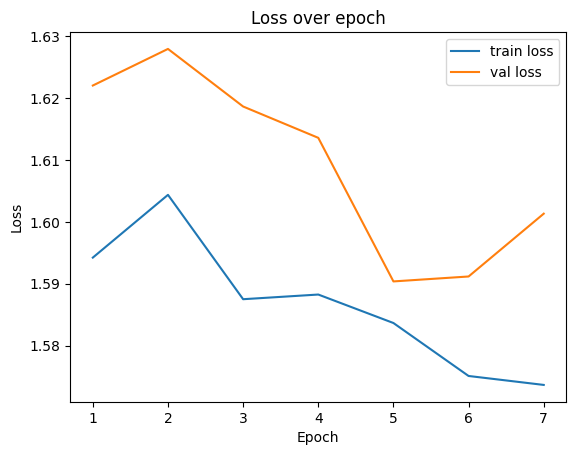

TransformerClassifier(
  (embedding): Embedding(6032, 512)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [38]:
trained_model = train(model, 50, train_loader, val_loader, device)
trained_model

In [41]:
print(f"Accuracy is {evaluate(trained_model, val_loader)}")

Accuracy is 0.17


In [45]:
example_text = "Covid is bad"
predicted_class_label = classify_text(model, example_text, tokenizer, dataset.vocab, sequence_length, device)
predicted_class = le.inverse_transform(predicted_class_label)
print(f"Predicted class: {predicted_class}")

Predicted class: ['Extremely Negative']
